# Model with GPT architecture for classification spam massages

In this approach, I replicated the GPT-2 architecture in order to load pretrained weights from OpenAI and extend the model with a classification head for text classification tasks.

However, due to the class imbalance in the dataset, it may be more effective to leverage the model in a way that aligns with its original purpose—generative modeling. Specifically, we propose fine-tuning the pretrained GPT-2 model on the underrepresented class to generate additional synthetic samples. This augmentation strategy aims to balance the dataset and improve classification performance by enriching the training data with contextually relevant examples.

<br> Data set is provided form [`UC Irvine`](https://archive.ics.uci.edu/)

## Outline
- [ 1 - Results](#1)
- [ 2 - Import Data](#2)
- [ 3 - Agmentation spam data by generating new text after finetuning model](#3)
- [ 4 - Finetune classification model on balanced dataset](#4)

<a name="1"></a>
## 1 - Results

In [317]:
print(classification_report(df_with_pred["Label"], df_with_pred["Pred"]))

              precision    recall  f1-score   support

         ham       0.96      0.99      0.98       955
        spam       0.99      0.96      0.98       975

    accuracy                           0.98      1930
   macro avg       0.98      0.98      0.98      1930
weighted avg       0.98      0.98      0.98      1930



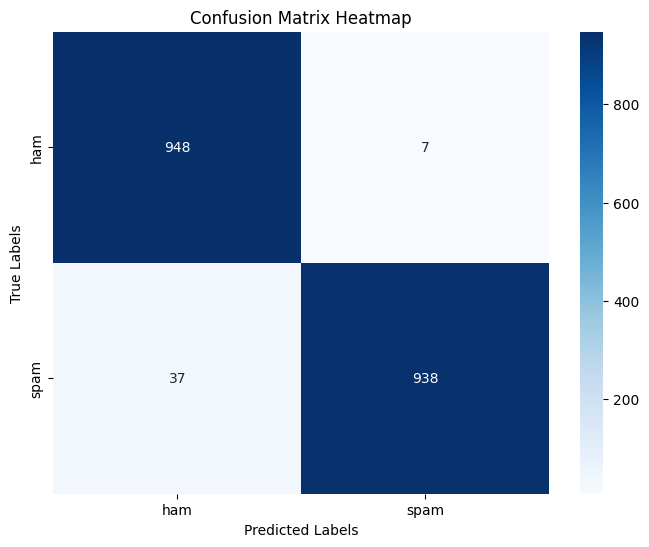

In [318]:
plot_confusion_matrix(df_with_pred["Label"], df_with_pred["Pred"])

In [319]:
examples = make_predictions(model_class, test_df, batch_size = None, num_examples = 3)

Processing Batches: 100%|██████████| 2/2 [00:00<00:00,  5.62it/s]


In [334]:
for i in range(len(examples)):
    print(f"Example {i}, text:\n {examples.loc[i][0]}\n true label: {examples.loc[i][1]}, predicted label: {examples.loc[i][2]}")

Example 0, text:
 18240 shows that u! Only 150ppm on tv. 16+. GBP1.50/week.
 true label: spam, predicted lable: spam
Example 1, text:
 ROMCAPspam Everyone around should be responding well to your presence since u r strong there. Psychic? Reply ANS. po pinc txt Stop to No: 81014649 NOW
 true label: spam, predicted lable: spam
Example 2, text:
 Loans for Nokias or Poly charity for polys 1 weekly @ 150p Please call poly/120p 16+only!
 true label: spam, predicted lable: spam
Example 3, text:
 Ok i wont call or disturb any one. I know all are avoiding me. I am a burden for all
 true label: ham, predicted lable: ham
Example 4, text:
 Where do you need to go to get it?
 true label: ham, predicted lable: ham
Example 5, text:
 Goodmorning,my grandfather expired..so am on leave today.
 true label: ham, predicted lable: ham


<a name="2"></a>
## 2 - Import Data

In [222]:
import os
import urllib.request
from torch.utils.data import Dataset, DataLoader
import torch
import pandas as pd
import urllib.request
import ssl
import zipfile
import os
from pathlib import Path
import time
from tqdm import tqdm
import importlib

import matplotlib.pyplot as plt

import tiktoken

import GPT_manual_architecture as GPT_model

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import seaborn as sns

#Thise is my .py file with whole GPT architecture
import GPT_manual_architecture as GPT_model

#File for downloading weights and load them into model
from download_wights import download_and_load_gpt2, load_weights_into_gpt

#File for creating Dataloaders
import Dataset_dataloader as Loader

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [ ]:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    """
    Function that download dataset
    
    Returns:
    path where file is download
    """
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Create an unverified SSL context
    ssl_context = ssl._create_unverified_context()

    # Downloading the file
    with urllib.request.urlopen(url, context=ssl_context) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

In [284]:
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])

In [71]:
target_names = df["Label"].unique()
num_classes = df["Label"].nunique()

In [48]:
def plot_lable(df):
    label_counts = df['Label'].value_counts()
    fig, ax = plt.subplots(figsize=(8,6))
    wedges, texts, autotexts = ax.pie(label_counts, autopct='%1.1f%%', startangle=90)
    
    ax.axis('equal')
    ax.set_title('Proportion of Labels in Train Dataset')
    ax.legend(wedges, target_names, title="Labels", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.show()

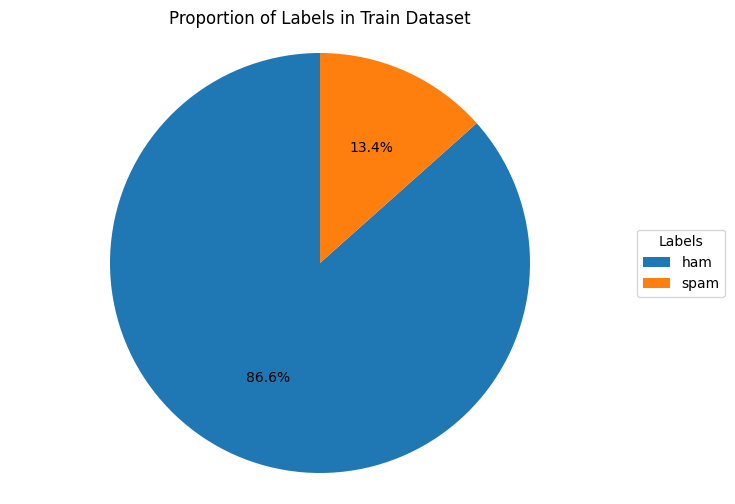

In [6]:
plot_lable(df)

In [8]:
tokenizer = tiktoken.get_encoding("gpt2")

In [9]:
#Let's define basic parameters for GPT-2 model
CHOOSE_MODEL = "gpt2-small (124M)"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.1,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [10]:
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

In [12]:
#Download pretrained weights
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/checkpoint


/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/encoder.json


/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/hparams.json


/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001


/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.index


/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.meta


/opt/anaconda3/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/vocab.bpe


<a name="3"></a>
## 3 - Agmentation spam data by generating new text after finetuning model

Let's fine tune pretrained model on spam texts in order to generate new spam data to augment dataset

In [84]:
spam_df = df[df["Label"]=="spam"]["Text"]

In [86]:
train_loader = Loader.create_dataloader_v1(
    tokenizer,
    spam_df,
    batch_size=2,
    max_length=BASE_CONFIG["context_length"],
    stride=BASE_CONFIG["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0,
    proc_type = "generate_next_word"
)

In [16]:
augment_model = GPT_model.GPTModel(BASE_CONFIG)
load_weights_into_gpt(augment_model, params)

In [17]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss
    
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [18]:
if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

In [19]:
augment_model.to(device)
torch.manual_seed(123)

In [20]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [21]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=50256):
    """
    Function that generate text based on given parameters

    Parameters:
    model - trained model
    inx - starting token index
    max_new_tokens - numbers of maximum tokens to generate
    context_size - one of basick parameters for GPT model
    temperature - parameter that control "craetivity" of model
    top_k - parameter to make the output less deterministic and more diverse
    eos_id - spechial token id for end of text
    
    Returns:
    list of indexies
    """
    batch_size = idx.size(0)
    finished = torch.zeros(batch_size, dtype=torch.bool, device=idx.device)  # Tracks which sequences are done

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1].unsqueeze(1)
            logits = torch.where(logits < min_val, torch.full_like(logits, float('-inf')), logits)

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch, 1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Update finished sequences
        if eos_id is not None:
            eos_hit = (idx_next == eos_id).squeeze(1)  # (batch,)
            finished = finished | eos_hit  # mark sequences as finished
            if finished.all():
                break  # All sequences have finished

        # Append tokens
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [22]:
def text_to_token_ids(text, tokenizer):
    """
    Function that convert text to token ids from given tokenizer

    text - text string
    
    Returns:
    list of indexies
    """
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor
    
def token_ids_to_text(token_ids, tokenizer):
    """
    Function that convert indexies to coresponging words from tokenizer
    
    Returns:
    list of words
    """
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [23]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size,
            top_k=25,
            temperature=1.4
        )

    decoded_text = token_ids_to_text(token_ids, tokenizer)
    # decoded_text = decoded_text.split("<|endoftext|>")[0]
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [24]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() 
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  
            optimizer.step() 
            tokens_seen += input_batch.numel()  
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch + 1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [40]:
start_time = time.time()

augment_model.to(device)
optimizer = torch.optim.AdamW(augment_model.parameters(), lr=0.001, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    augment_model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Congrats!", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 7.987, Val loss 7.929
Ep 1 (Step 000005): Train loss 5.188, Val loss 5.037
Ep 1 (Step 000010): Train loss 4.509, Val loss 4.319
Congrats! 1st attempt will get your cash txts, your complimentary colour camera. £350.50
Ep 2 (Step 000015): Train loss 3.895, Val loss 3.968
Ep 2 (Step 000020): Train loss 3.397, Val loss 3.259
Ep 2 (Step 000025): Train loss 3.028, Val loss 2.793
Congrats! 1st week free T&Cs Rply POLYPHONICALLY AWARD! Only 10p per message: Rply shrgxxy420giftk11/10pm-stop. PoBox398x.
Ep 3 (Step 000030): Train loss 2.476, Val loss 2.544
Ep 3 (Step 000035): Train loss 2.148, Val loss 1.977
Ep 3 (Step 000040): Train loss 1.812, Val loss 1.668
Congrats! Uptown Admirer! 1Winaweed!Age16 -18/MobsmoreFrmMob.shp 4 more
Ep 4 (Step 000045): Train loss 1.437, Val loss 1.552
Ep 4 (Step 000050): Train loss 1.102, Val loss 1.119
Ep 4 (Step 000055): Train loss 1.020, Val loss 1.053
Congrats!Win the latest Ringtone from 2004!SKY OPT OUT 08701418720201 PO BOX 3W4

In [41]:
#save trained model
torch.save(augment_model.state_dict(), "model_for_augmentation.pth")

In [26]:
if os.path.exists("model_for_augmentation.pth"):
    augment_model.load_state_dict(torch.load("model_for_augmentation.pth"))
    augment_model.to("cpu")
    augment_model.eval()

/var/folders/tr/8w0nm2r933q2n7ws8zrfc_n40000gn/T/ipykernel_23976/1047902958.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  augment_model.load_state_dict(torch.load("mod

In [45]:
# example of generating spam message
token_ids = generate(
    model=augment_model,
    idx=text_to_token_ids("Congrats", tokenizer),
    max_new_tokens=70,
    context_size=BASE_CONFIG["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Congrats 1 year special cinema pass for 2 is yours. call 09061209465 now! C Suprman V, Matrix3, StarWars3, etc all 4 FREE! bx420-ip4-5we. 150pm. Dont miss out! 


In [37]:
num_aumented_texts = len(df[df["Label"] == df["Label"].unique()[0]]) - len(df[df["Label"] == df["Label"].unique()[1]])

In [98]:
# Generating messages to create balanced dataset. I took starting words from original spam dataset

data = []
starting_words = list(set(spam_df.str.split().str[0].tolist()))
for _ in tqdm(range(num_aumented_texts), desc="Text"):
    import random
    start_word = random.choice(starting_words)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(start_word, tokenizer),
        max_new_tokens=70,
        context_size=BASE_CONFIG["context_length"],
        top_k=25,
        temperature=2
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    data.append({"Text": generated_text, "Label": "spam"})

# Convert to DataFrame
df_augmented = pd.DataFrame(data)      
df_combined = pd.concat([df, df_augmented], ignore_index=True)

Text: 100%|██████████| 4078/4078 [48:15<00:00,  1.41it/s]  


In [ ]:
df_combined.to_csv("augmented_df.csv", index=False)

In [263]:
df_augm = pd.read_csv("augmented_df.csv")

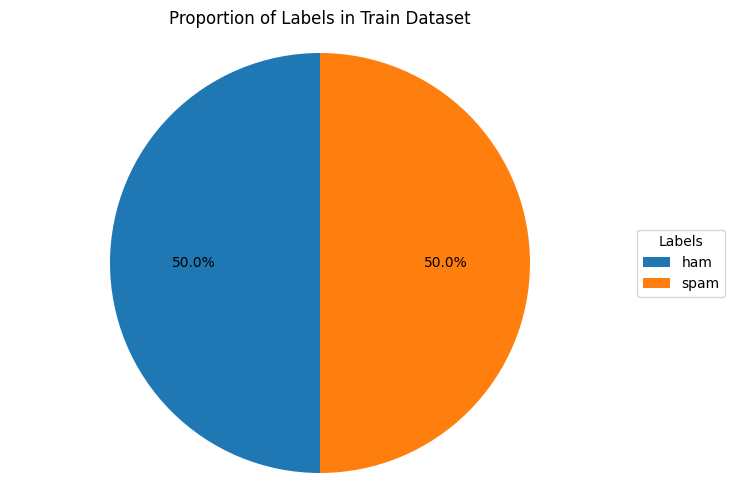

In [49]:
plot_lable(df_augm)

<a name="4"></a>
## 4 - Finetune classification model on balanced dataset

In [264]:
df_augm["Label"] = df_augm["Label"].map({"ham": 0, "spam": 1})

In [309]:
def random_split(df, validation_frac):
    df = df.sample(frac=1).reset_index(drop=True)

    train_end = int(len(df) * validation_frac)

    train_df = df[train_end:]
    validation_df = df[:train_end]

    return train_df, validation_df
    
train_df, test_df = random_split(df_augm, 0.2)

In [268]:
train_class_loader = Loader.create_dataloader_v1(
    tokenizer,
    train_df,
    batch_size=8,
    max_length=BASE_CONFIG["context_length"],
    stride=BASE_CONFIG["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0,
    proc_type="classification"
)

test_class_loader = Loader.create_dataloader_v1(
    tokenizer,
    test_df,
    batch_size=8,
    max_length=BASE_CONFIG["context_length"],
    stride=BASE_CONFIG["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0,
    proc_type="classification"
)

In [269]:
model_class = GPT_model.GPTModel(BASE_CONFIG)
load_weights_into_gpt(model_class, params)
model_class.eval();

In [270]:
for param in model_class.parameters():
    param.requires_grad = False

# Adding classification head ontop of last layer of GPT model. So that it cold predict only based on 2 classes instead of whole dictionary
model_class.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

In [271]:
#Let's unfreeze last layer of all transformer blocks
for param in model_class.trf_blocks[-1:].parameters():
    param.requires_grad = True

for param in model_class.final_norm.parameters():
    param.requires_grad = True

In [272]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

In [273]:
def train_classifier(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{num_epochs}")
        for input_batch, target_batch in progress_bar:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1

        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=None)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=None)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [274]:
model_class.to(device)

num_epochs = 5
optimizer = torch.optim.AdamW(model_class.parameters(), lr=5e-5, weight_decay=0.1)

train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier(
        model_class, train_class_loader, test_class_loader, optimizer, device, num_epochs=num_epochs, eval_freq=50, eval_iter=5
    )

Training Epoch 1/5: 100%|██████████| 965/965 [04:38<00:00,  3.47it/s]


Training accuracy: 95.13% | Validation accuracy: 94.87%


Training Epoch 2/5: 100%|██████████| 965/965 [23:38<00:00,  1.47s/it]    


Training accuracy: 96.35% | Validation accuracy: 96.11%


Training Epoch 3/5: 100%|██████████| 965/965 [04:39<00:00,  3.45it/s]


Training accuracy: 96.36% | Validation accuracy: 96.32%


Training Epoch 4/5: 100%|██████████| 965/965 [04:40<00:00,  3.44it/s]


Training accuracy: 96.68% | Validation accuracy: 96.52%


Training Epoch 5/5: 100%|██████████| 965/965 [04:40<00:00,  3.45it/s]


Training accuracy: 97.33% | Validation accuracy: 97.10%


In [133]:
torch.save(model_class.state_dict(), "model_for_classification.pth")

In [311]:
def make_predictions(model, df, batch_size = None, num_examples = None, pad_token_id = 50256):
    """
    Function that create predictions eather for all dataset or for given numbers of examples randomly peacked from dataset
    
    Returns:
    Dataframe with original text, true label and predicted label 
    """
    if num_examples == "All":
        batch_data = df.copy()
        if batch_size == None:
            batch_size = 8
    else:
        if batch_size == None:
            batch_size = num_examples

        elif batch_size > num_examples:
            batch_size = num_examples

        data_spam = df[df["Label"] == 1].sample(num_examples)
        data_nospam = df[df["Label"] == 0].sample(num_examples)
        batch_data = pd.concat([data_spam,data_nospam], ignore_index = True)


    encoded_texts = [
                tokenizer.encode(text) for text in batch_data["Text"]
            ]
    
    max_length = 0
    for encoded_text in encoded_texts:
        encoded_length = len(encoded_text)
        if encoded_length > max_length:
            max_length = encoded_length
    
                
    encoded_texts = [
            encoded_text[:max_length]
            for encoded_text in encoded_texts
        ]
    
    encoded_texts = [
                encoded_text + [pad_token_id] * (max_length - len(encoded_text))
                for encoded_text in encoded_texts
            ]
    pred_list = []
    for i in tqdm(range(0, len(encoded_texts), batch_size), desc="Processing Batches"):
        input_tensor = torch.tensor(encoded_texts[i:i+batch_size], device=device)

        with torch.no_grad():
            logits = model(input_tensor)[:, -1, :]
        
        predictions = torch.argmax(logits, dim=-1)
        pred_list.extend(predictions.cpu().numpy())

    batch_data.loc[:, "Pred"] = pred_list

    batch_data["Label"] = batch_data["Label"].map({0: "ham", 1: "spam"})
    batch_data["Pred"] = batch_data["Pred"].map({0: "ham", 1: "spam"})
    
    return batch_data[["Text", "Label", "Pred"]]

In [312]:
df_with_pred = make_predictions(model_class, test_df, batch_size = None, num_examples = "All")

Processing Batches: 100%|██████████| 242/242 [00:43<00:00,  5.51it/s]


In [211]:
def plot_confusion_matrix(Y_true, Y_pred):
    cm = confusion_matrix(Y_true, Y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    
    # Set plot labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

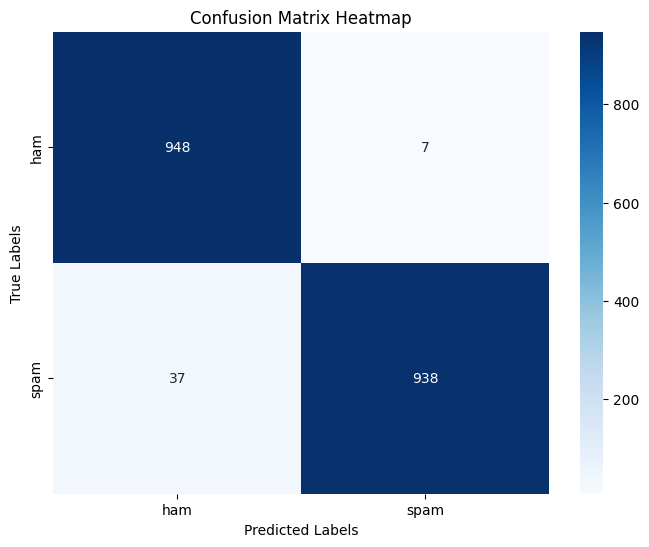

In [314]:
plot_confusion_matrix(df_with_pred["Label"], df_with_pred["Pred"])

In [315]:
print(classification_report(df_with_pred["Label"], df_with_pred["Pred"]))

              precision    recall  f1-score   support

         ham       0.96      0.99      0.98       955
        spam       0.99      0.96      0.98       975

    accuracy                           0.98      1930
   macro avg       0.98      0.98      0.98      1930
weighted avg       0.98      0.98      0.98      1930



In [316]:
accuracy_score(df_with_pred["Label"], df_with_pred["Pred"])

0.9772020725388602